# 合成コントロール法

In [173]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import gpboost as gpb
from patsy import dmatrices, dmatrix
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
path = '../../../../data/processed/scm_df_treatment_group.xlsx'
treatment_df = pd.read_excel(path)
path = '../../../../data/processed/scm_df_control_group.xlsx'
control_df = pd.read_excel(path)

In [204]:
treatment_df

,year,66,67,68,70,72,88,89,91,92,...,192,193,195,197,202,204,216,221,223,226
0,1970,8.405144,NaN,4.077537,6.956545,NaN,7.984463,7.909122,NaN,NaN,...,9.606563,9.213136,9.415401,7.346010,4.343805,7.026427,7.855545,4.983607,6.971669,NaN
1,1975,8.427050,NaN,3.828641,6.729824,NaN,7.843456,7.784889,NaN,NaN,...,9.508443,9.290537,9.372289,7.172425,4.304065,6.814543,7.780721,4.912655,6.981006,NaN
2,1980,8.301522,NaN,3.951244,6.660575,NaN,7.787797,7.694393,NaN,NaN,...,9.424564,9.249176,9.309280,7.060476,4.025352,6.682109,7.688455,4.890349,6.920672,6.641182
3,1985,8.435332,NaN,3.970292,6.533789,NaN,7.693482,7.605890,NaN,NaN,...,9.336532,9.212239,9.261509,6.931472,3.871201,6.459904,7.625107,4.955827,6.859615,NaN
4,1990,8.432724,NaN,3.988984,6.505784,NaN,7.659171,7.514800,NaN,NaN,...,9.233373,9.130756,9.209040,6.826545,3.737670,6.302619,7.518064,4.976734,6.779922,NaN
5,1995,8.433159,6.054439,3.806662,6.309918,7.266827,7.622175,7.416378,10.220850,6.748760,...,9.068201,9.030735,9.103979,6.709304,3.496508,6.159095,7.462215,4.948760,6.708084,6.035481
6,2000,8.430109,5.780744,2.772589,6.148468,6.981935,7.559559,7.321189,10.174087,6.678342,...,8.966739,8.991064,9.029178,6.548219,3.526361,5.961005,7.159292,4.820282,6.658011,5.986452
7,2005,8.371242,5.710427,2.564949,6.137727,6.735780,7.470224,7.178545,10.120211,6.594413,...,8.875427,8.899458,8.951570,6.349139,3.496508,5.840642,7.118016,4.605170,6.520621,5.899897
8,2010,8.311890,5.579730,2.484907,5.993961,6.522093,7.396335,7.095893,10.065181,6.475433,...,8.778634,8.844481,8.862767,6.018593,3.401197,5.758902,6.972606,4.454347,6.354370,5.837730
9,2015,8.253748,5.283204,2.302585,6.001415,6.186209,7.299797,6.968850,10.012835,6.338594,...,8.643826,8.757626,8.704668,5.739793,3.178054,5.488938,6.834109,4.204693,6.190315,5.648974


In [236]:
y = treatment_df['68']
len(y)

29

In [237]:
X = control_df.drop(columns=['year'])
X.shape

(29, 105)

In [238]:
alpha_OLS = np.linalg.inv(X.T @ X) @ X.T @ y

In [239]:
print(alpha_OLS.round(3))
print(alpha_OLS.sum())

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
100   NaN
101   NaN
102   NaN
103   NaN
104   NaN
Length: 105, dtype: float64
0.0


<Axes: xlabel='year', ylabel='None'>

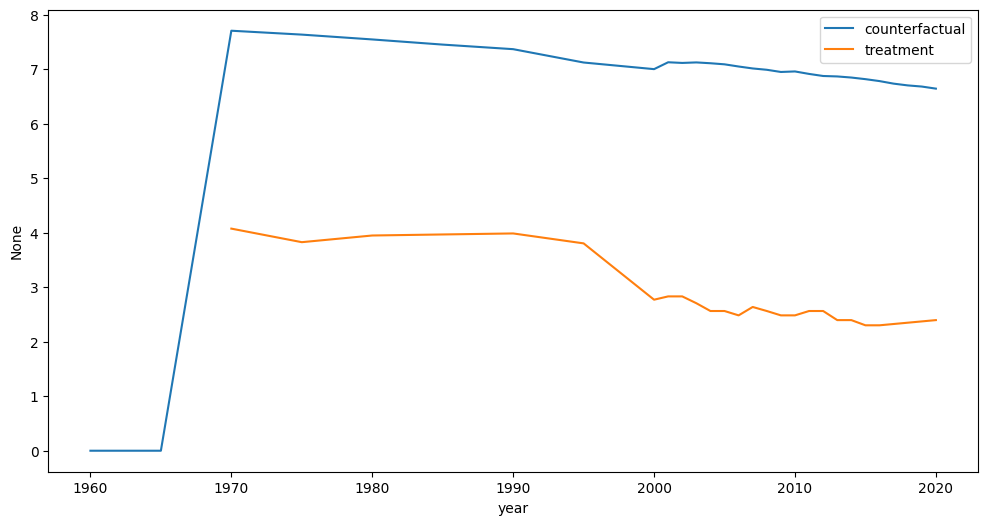

In [240]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=control_df['year'], y=y_hat, label='counterfactual')
sns.lineplot(x=treatment_df['year'], y=y, label='treatment')

In [241]:
T = len(control_df['year'].unique()) # 観測された時間の長さ
N = control_df.columns.nunique() - 1 # control unitの数


# MSE(平均二乗誤差)を損失関数として、その最小化をする
def loss_function(w, X, y):
    return np.mean((y - X @ w)**2)

cons = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
)
bounds = [(0, None) for i in range(N)]

alpha_init = np.ones(N) / N
scm = minimize(
    loss_function,
    x0=alpha_init,
    args=(X, y),
    constraints=cons,
    bounds=bounds,
    method="SLSQP"
)
alpha_scm = scm.x
print(alpha_scm.round(4))
print(alpha_scm.sum())

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.3288 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.4637
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.2075 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.    ]
1.0000000000000038


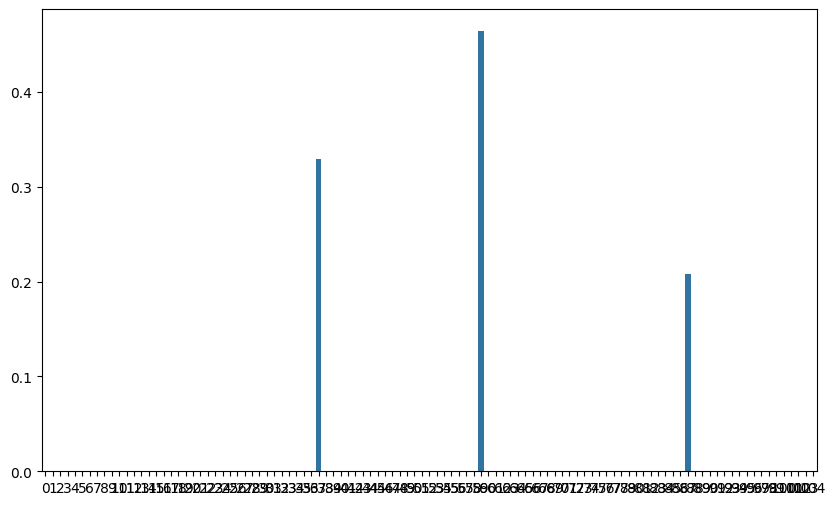

In [242]:
plt.figure(figsize=(10, 6))
sns.barplot(alpha_scm)
plt.show()

In [243]:
y_hat = np.sum(alpha_scm.T * X, axis=1)

<Axes: xlabel='year', ylabel='None'>

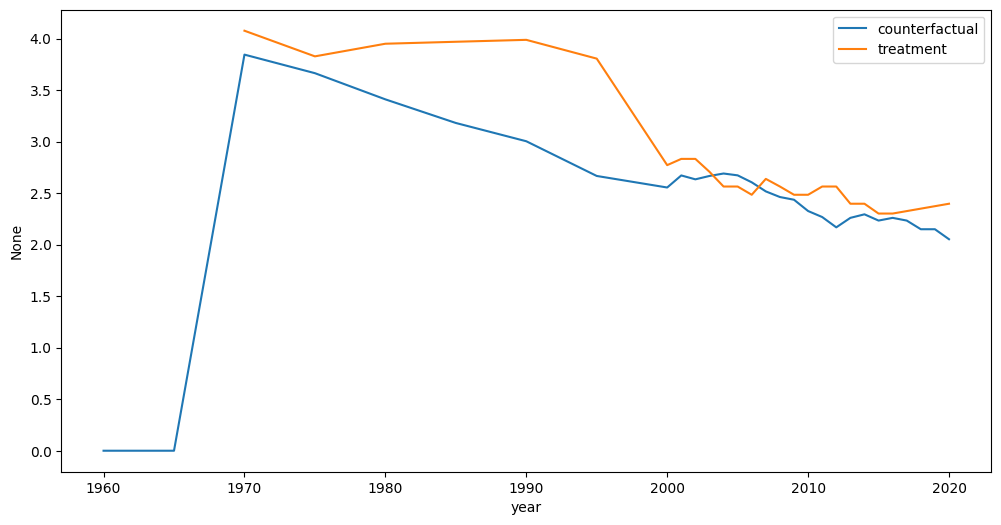

In [244]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=control_df['year'], y=y_hat, label='counterfactual')
sns.lineplot(x=treatment_df['year'], y=y, label='treatment')